## I think this notebook is now superflous as I'm pretty sure I just remade it but better and cleaner in results.ipynb, so it's off to the ancillary notes directory.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as fits
import glob
import os
from sklearn.neighbors import KDTree

In [2]:
plt.style.use('default')
plt.style.use('ggplot')

In [3]:
# our stellar models:

with np.load('model_atm_mags.npz') as nump_zip:
    model_atm_mags = nump_zip['model_atm_mags']

In [4]:
# our "data":

temp = np.load('truth_catalog.npz')
truth_catalog = temp['truth_catalog'].copy()
temp.close()

Checking that I did the zipping and unzipping right:

In [5]:
truth_catalog.dtype

dtype([('Teff', '<f8'), ('log_Z', '<f8'), ('gravity', '<f8'), ('F378', '<f8'), ('F395', '<f8'), ('F410', '<f8'), ('F430', '<f8'), ('F515', '<f8'), ('F660', '<f8'), ('F861', '<f8'), ('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('y', '<f8')])

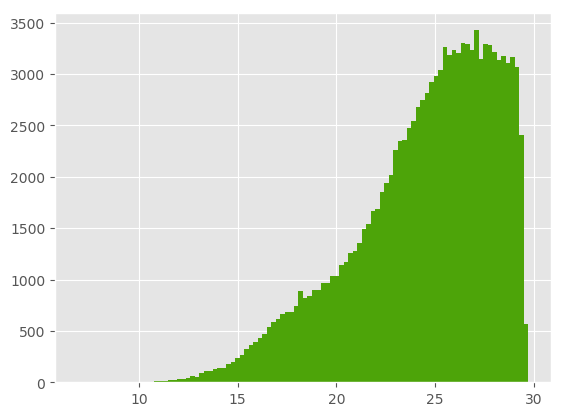

In [6]:
ack = plt.hist(truth_catalog['g'], bins=100, color='xkcd:Lawn Green')

Looks like it's supposed to. Moving on, copypasting the last bit of the previous notebook here, so the kdtrees and the LSST depth uncertainty-adding can be in one notebook.

## Broadband Tree:

In [7]:
color1 = model_atm_mags['u'] - model_atm_mags['g']
color2 = model_atm_mags['g'] - model_atm_mags['r']
color3 = model_atm_mags['r'] - model_atm_mags['i']
color4 = model_atm_mags['i'] - model_atm_mags['z']
color5 = model_atm_mags['z'] - model_atm_mags['y']

mag_model = np.array([color1, color2, color3, color4, color5]).T

In [8]:
broadleafed_tree = KDTree(mag_model)

In [9]:
bcolor1 = truth_catalog['u'] - truth_catalog['g']
bcolor2 = truth_catalog['g'] - truth_catalog['r']
bcolor3 = truth_catalog['r'] - truth_catalog['i']
bcolor4 = truth_catalog['i'] - truth_catalog['z']
bcolor5 = truth_catalog['z'] - truth_catalog['y']

sim_colors = np.array([bcolor1, bcolor2, bcolor3, bcolor4, bcolor5]).T
dist_bcolors, indx_match_bcolors = broadleafed_tree.query(sim_colors, k=1)

## Narrowband Tree:

In [10]:
model_ncolor0 = model_atm_mags['F861'] - model_atm_mags['z']
model_ncolor1 = model_atm_mags['r'] - model_atm_mags['F660']
model_ncolor2 = model_atm_mags['g'] - model_atm_mags['F515']
model_ncolor3 = model_atm_mags['F430'] - model_atm_mags['g']
model_ncolor4 = model_atm_mags['F410'] - model_atm_mags['g']
# could really go with either:
model_ncolor5a = model_atm_mags['F395'] - model_atm_mags['g']
# or:
model_ncolor5b = model_atm_mags['u'] - model_atm_mags['F395']
# or both, I suppose, if there's anything to be gained from doing so.
model_ncolor6 = model_atm_mags['u'] - model_atm_mags['F378']

ncolormodel = np.array(
    [model_ncolor0, model_ncolor1, model_ncolor2, model_ncolor3, model_ncolor4, model_ncolor5b, model_ncolor6]
).T

In [11]:
narrowleafed_tree = KDTree(ncolormodel)

In [12]:
nbcolor0 = truth_catalog['F861'] - truth_catalog['z']
nbcolor1 = truth_catalog['r'] - truth_catalog['F660']
nbcolor2 = truth_catalog['g'] - truth_catalog['F515']
nbcolor3 = truth_catalog['F430'] - truth_catalog['g']
nbcolor4 = truth_catalog['F410'] - truth_catalog['g']
# again, could really go with either:
nbcolor5a = truth_catalog['F395'] - truth_catalog['g']
# or:
nbcolor5b = truth_catalog['u'] - truth_catalog['F395']
# or both.
nbcolor6 = truth_catalog['u'] - truth_catalog['F378']

nbsim_colors = np.array([nbcolor0, nbcolor1, nbcolor2, nbcolor3, nbcolor4, nbcolor5b, nbcolor6]).T
dist_nbcolors, indx_match_nbcolors = narrowleafed_tree.query(nbsim_colors, k=1)

Checking that nothing's gone horribly wrong in the transportation from the last notebook:

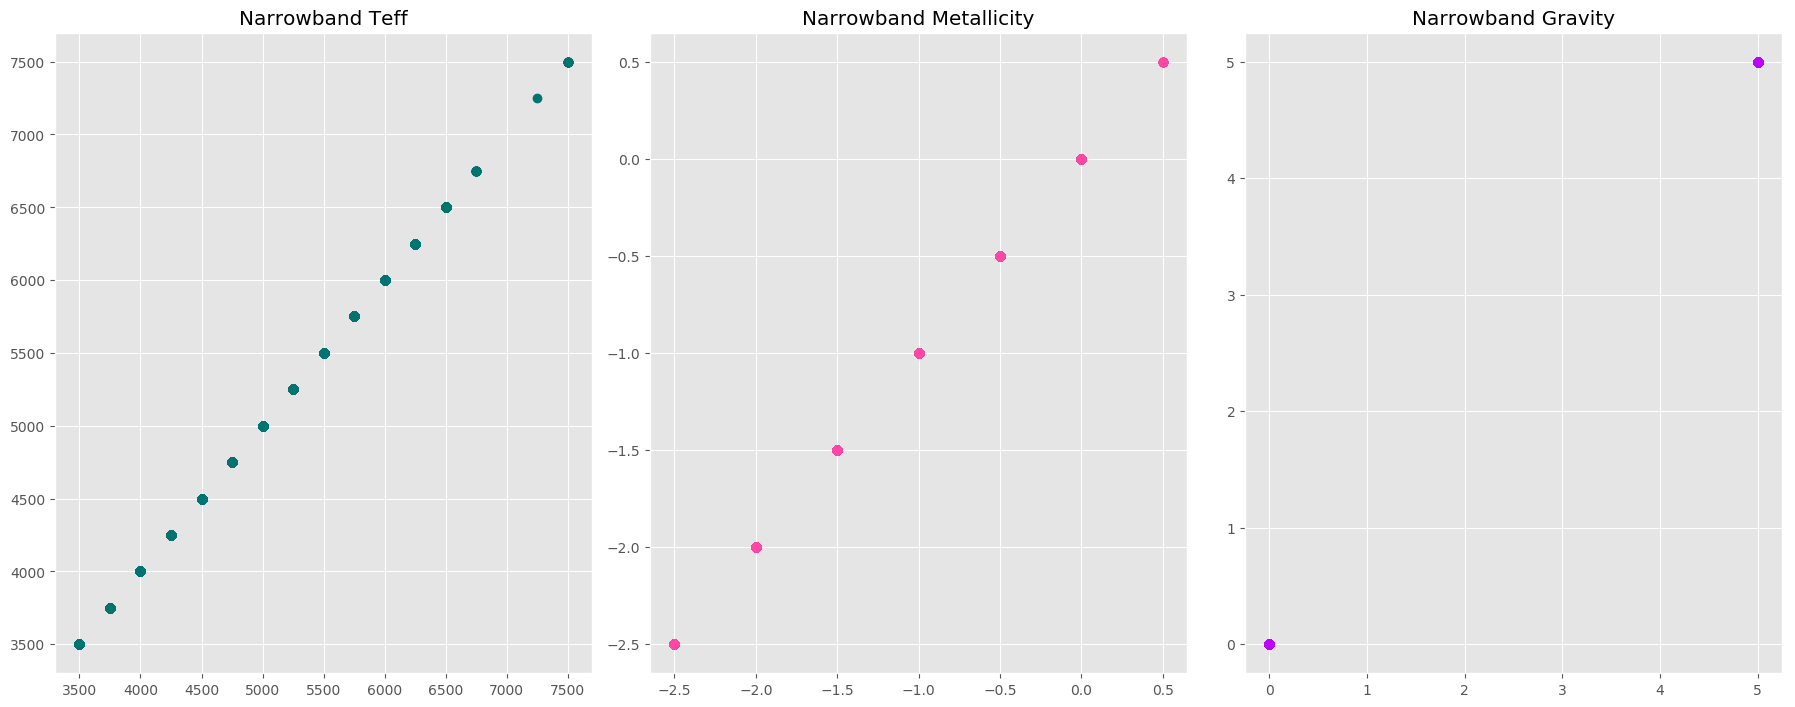

In [13]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,7)

fig.tight_layout()

ax[0].set_title('Narrowband Teff')
ax[0].plot(truth_catalog['Teff'], model_atm_mags['Teff'][indx_match_nbcolors], 'ko', c='xkcd:Dark Aquamarine')

ax[1].set_title('Narrowband Metallicity')
ax[1].plot(truth_catalog['log_Z'], model_atm_mags['log_Z'][indx_match_nbcolors], 'ko', c='xkcd:Barbie Pink')

ax[2].set_title('Narrowband Gravity')
ax[2].plot(truth_catalog['gravity'], model_atm_mags['gravity'][indx_match_nbcolors], 'ko', c='xkcd:Bright Purple');

In [14]:
# Double check that we only have 2 unique gravities in the truth
np.unique(truth_catalog['gravity'])

array([0., 5.])

Well, that's a relief!

Merging my noise-adding cells with yours below.

# Bringing the noise:

Yes me just pasting the numbers right there rather than making them into a table or something and then importing it in is really lazy. I'm okay with that.

In [15]:
# S/N Function. The magnitudes in truth_catalog will make up the former argument, and those numbers directly above,
# the latter. I hope, anyway, because that's what I'm doing.

def m52snr(m, m5):
    """
    Calculate the SNR for a star of magnitude m in an
    observation with 5-sigma limiting magnitude depth m5.
    Assumes gaussian distribution of photons and might not be
    strictly due in bluer filters. See table 2 and equation 5
    in astroph/0805.2366.

    Parameters
    ----------
    m : float or numpy.ndarray
        The magnitude of the star
    m5 : float or numpy.ndarray
        The m5 limiting magnitude of the observation

    Returns
    -------
    float or numpy.ndarray
        The SNR
    """
    snr = 5.*10.**(-0.4*(m-m5))
    return snr

In [16]:
def mag_error(m, snr):
    # https://www.eso.org/~ohainaut/ccd/sn.html
    dmag = 2.5*np.log10(1.+1./snr)
    return dmag

In [17]:
mag_names = ['u', 'g', 'r', 'i', 'z', 'y'] # maybe not needed

mag_depths_10yrs = {'u': 25.593438315651625, 
    'g': 27.058813369707448, 
    'r': 27.136312824636949, 
    'i': 26.571196315062267, 
    'z': 25.653425773525129, 
    'y': 24.856152336639905}

In [18]:
# Set the random number seed to make things repeatable.

np.random.seed(42)

# Let's make some as-observed mags.

observations = np.zeros(truth_catalog.size, dtype=list(zip(mag_names, [float]*len(mag_names))))
for filtername in mag_names:
    
    # SNR for each star
    
    snrs = m52snr(truth_catalog[filtername], mag_depths_10yrs[filtername])
    
    # Magnitude errors for each star
    
    mag_errors_realize = mag_error(truth_catalog[filtername], snrs)
    
    # 'Observed' mags for each star (original mag + error)
    
    observations[filtername] = truth_catalog[filtername] + np.random.randn(truth_catalog[filtername].size)*mag_errors_realize

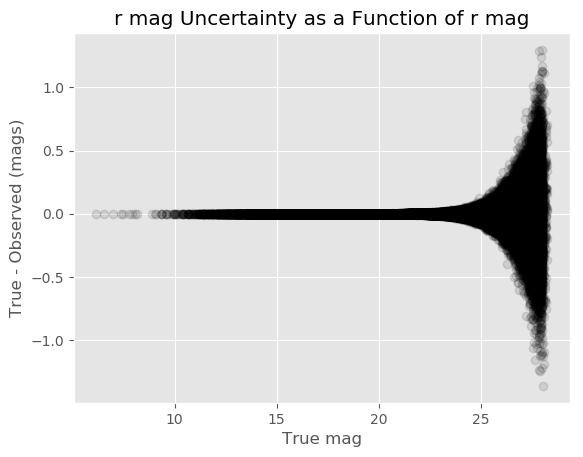

In [19]:
# A quick visual check on observed magnitudes:

plt.plot(truth_catalog['r'], truth_catalog['r']-observations['r'], 'ko', alpha=.1)
plt.xlabel('True mag')
plt.ylabel('True - Observed (mags)')
plt.title('r mag Uncertainty as a Function of r mag');

Note, LSST saturates around 16-18, so those are not real. Also the graph looks like a rotational volume integration problem they'd give you in calculus II.

In [20]:
# OK, now we have observed magnitudes. Now converting to colors and machine learning it up.

obscolor1 = observations['u'] - observations['g'] # u-g
obscolor2 = observations['g'] - observations['r'] # g-r
obscolor3 = observations['r'] - observations['i'] # r-i
obscolor4 = observations['i'] - observations['z'] # i-z
obscolor5 = observations['z'] - observations['y'] # z-y

obs_colors = np.array([obscolor1, obscolor2, obscolor3, obscolor4, obscolor5]).T
dist_obscolors, indx_match_obscolors = broadleafed_tree.query(obs_colors, k=1)

In [21]:
# Collapse the dimensionality so memory usage doesn't do very bad things - agreed!
indx_match_obscolors = indx_match_obscolors[:,0]

In [22]:
teff_diff = np.array(truth_catalog['Teff']-model_atm_mags['Teff'][indx_match_obscolors])
Z_diff = np.array(truth_catalog['log_Z']-model_atm_mags['log_Z'][indx_match_obscolors])
G_diff = np.array(truth_catalog['gravity']-model_atm_mags['gravity'][indx_match_obscolors])

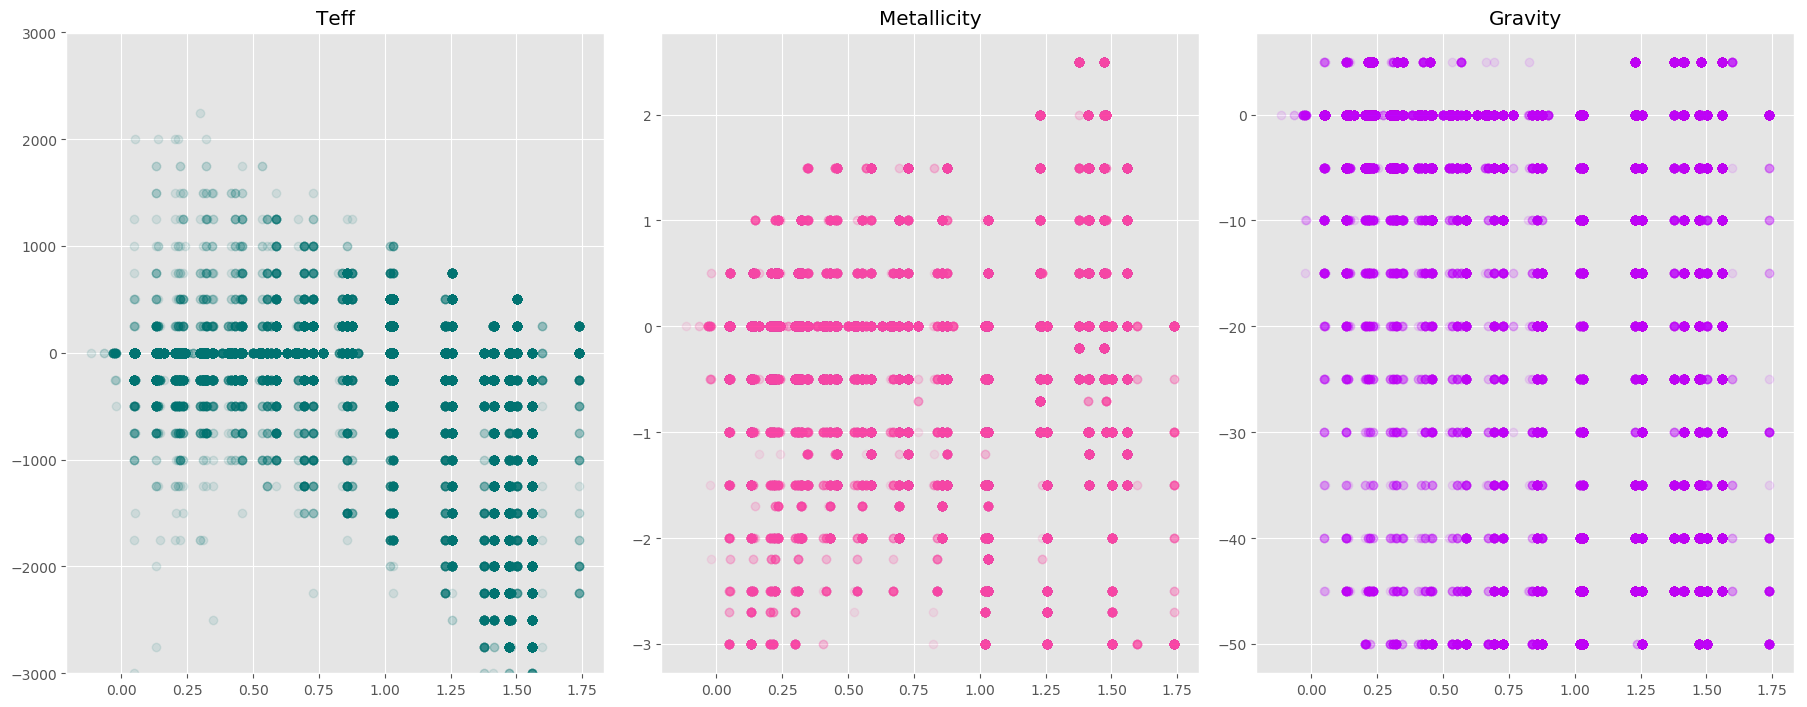

In [23]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,7)

fig.tight_layout()

# uncomment the two lines below if you want to make Teff look slightly less bad...

#ax[0].set_xlim(3500, 7600)
ax[0].set_ylim(-3000, 3000)

ax[0].set_title('Teff')
ax[0].plot(bcolor2, teff_diff, 'ko', c='xkcd:Dark Aquamarine', alpha=0.1)

ax[1].set_title('Metallicity')
ax[1].plot(bcolor2, Z_diff, 'ko', c='xkcd:Barbie Pink', alpha=0.1)

ax[2].set_title('Gravity')
ax[2].plot(bcolor2, G_diff, 'ko', c='xkcd:Bright Purple', alpha=0.1);

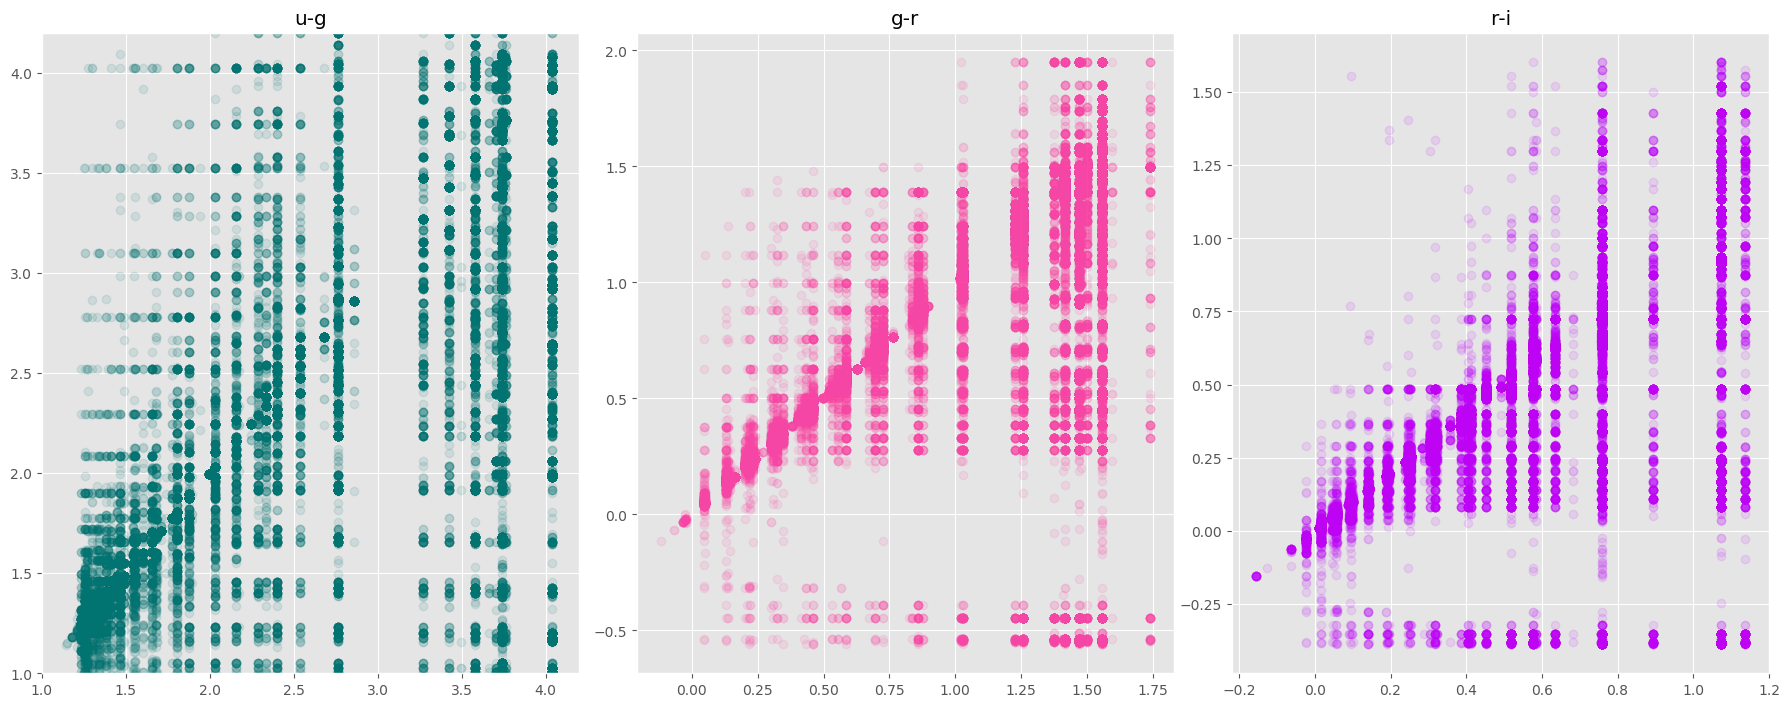

In [24]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,7)

fig.tight_layout()

ax[0].set_xlim(1, 4.2)
ax[0].set_ylim(1, 4.2)
ax[0].set_title('u-g')
ax[0].plot(bcolor1, color1[indx_match_obscolors], 'ko', c='xkcd:Dark Aquamarine', alpha=0.1)

ax[1].set_title('g-r')
ax[1].plot(bcolor2, color2[indx_match_obscolors], 'ko', c='xkcd:Barbie Pink', alpha=0.1)

ax[2].set_title('r-i')
ax[2].plot(bcolor3, color3[indx_match_obscolors], 'ko', c='xkcd:Bright Purple', alpha=0.1);

Trying g-r on its own.

In [25]:
indx_match_bcolors = indx_match_bcolors[:,0]

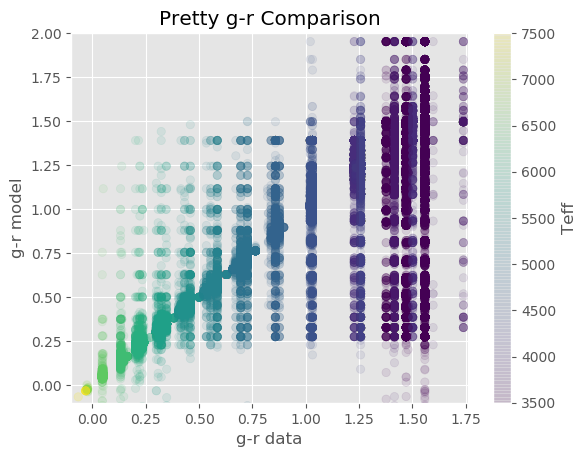

In [26]:
plt.scatter(bcolor2, color2[indx_match_obscolors], c=truth_catalog['Teff'], alpha=0.1)
cb = plt.colorbar()
cb.set_label('Teff')
plt.xlim(-0.1, 1.76)
plt.ylim(-0.1, 2)
plt.xlabel('g-r data')
plt.ylabel('g-r model')
plt.title('Pretty g-r Comparison');

Now g-r on its own but with the correct (un-noisified) line over it.

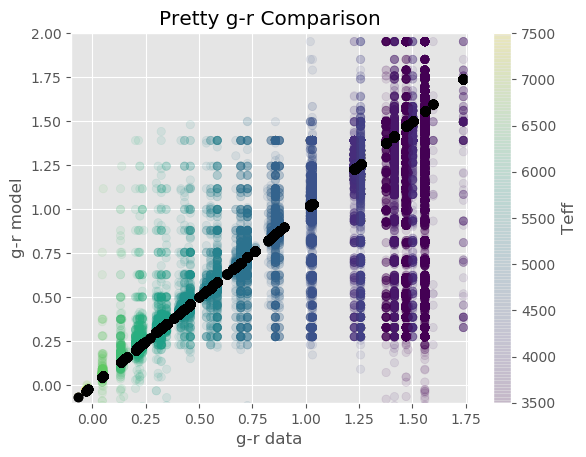

In [27]:
plt.scatter(bcolor2, color2[indx_match_obscolors], c=truth_catalog['Teff'], alpha=0.1)
plt.plot(bcolor2, color2[indx_match_bcolors], 'ko', c='xkcd:Black')
cb = plt.colorbar()
cb.set_label('Teff')
plt.xlim(-0.1, 1.76)
plt.ylim(-0.1, 2)
plt.xlabel('g-r data')
plt.ylabel('g-r model')
plt.title('Pretty g-r Comparison');

In [28]:
g_r_diff = np.array(bcolor2 - color2[indx_match_obscolors])

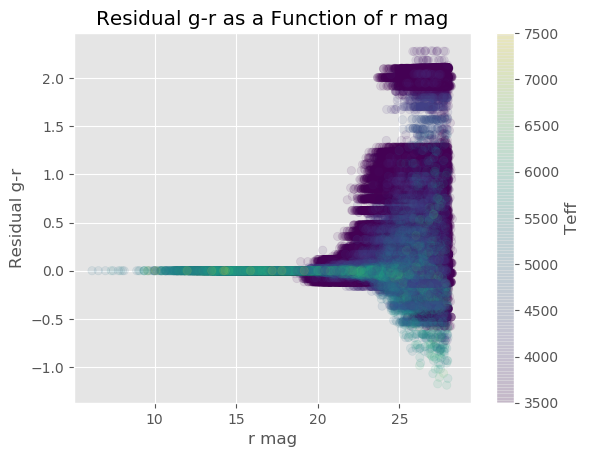

In [29]:
plt.scatter(truth_catalog['r'], g_r_diff, c=truth_catalog['Teff'], alpha=0.1)
cb = plt.colorbar()
cb.set_label('Teff')
#plt.xlim(-0.1, 1.76)
#plt.ylim(-0.1, 2)
plt.xlabel('r mag')
plt.ylabel('Residual g-r')
plt.title('Residual g-r as a Function of r mag');

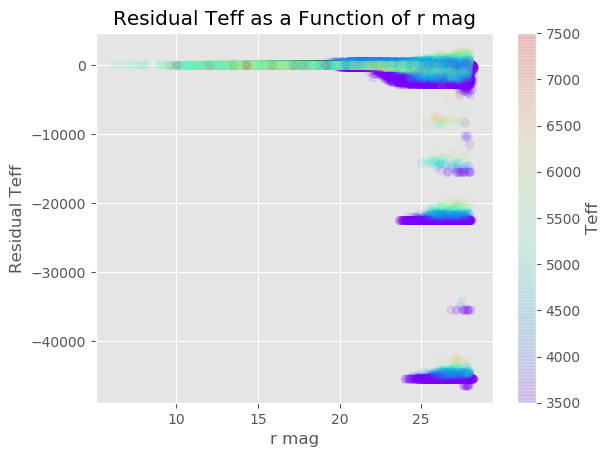

In [30]:
plt.scatter(truth_catalog['r'], teff_diff, c=truth_catalog['Teff'], cmap='rainbow', alpha=0.1)
cb = plt.colorbar()
cb.set_label('Teff')
plt.xlabel('r mag')
plt.ylabel('Residual Teff')
plt.title('Residual Teff as a Function of r mag');

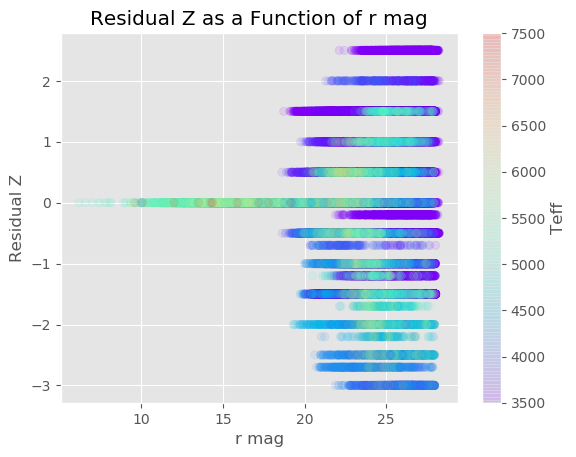

In [31]:
plt.scatter(truth_catalog['r'], Z_diff, c=truth_catalog['Teff'], cmap='rainbow', alpha=0.1)
cb = plt.colorbar()
cb.set_label('Teff')
plt.xlabel('r mag')
plt.ylabel('Residual Z')
plt.title('Residual Z as a Function of r mag');

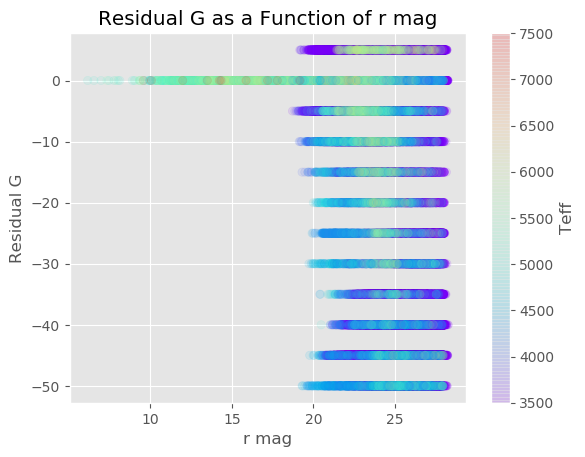

In [32]:
plt.scatter(truth_catalog['r'], G_diff, c=truth_catalog['Teff'], cmap='rainbow', alpha=0.1)
cb = plt.colorbar()
cb.set_label('Teff')
plt.xlabel('r mag')
plt.ylabel('Residual G')
plt.title('Residual G as a Function of r mag');

Let's look at the histogram at a spot:

In [33]:
selection = np.where( (truth_catalog['r'] > 23.5) & (truth_catalog['r'] < 24))[0]

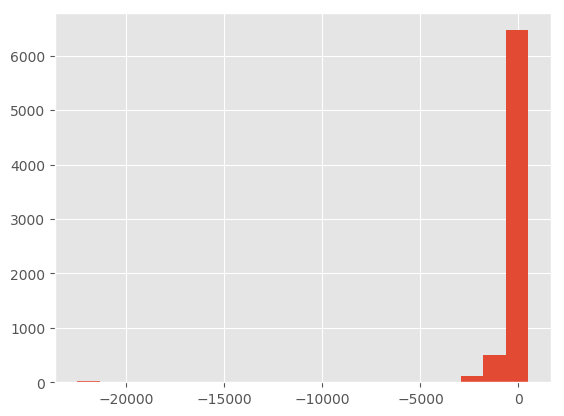

In [34]:
ack = plt.hist(teff_diff[selection], bins=20)

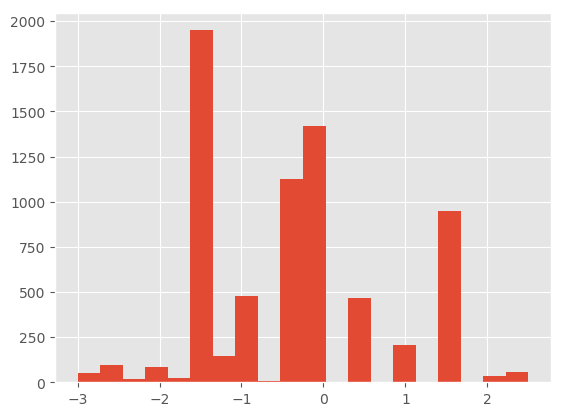

In [35]:
ack = plt.hist(Z_diff[selection], bins=20)

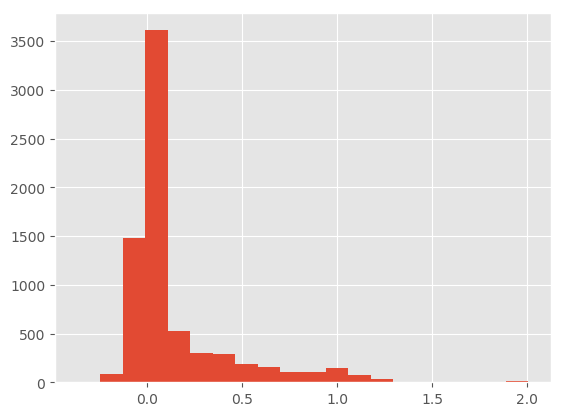

In [36]:
ack = plt.hist(g_r_diff[selection], bins=20)

In [37]:
# OK, I think this is success!  If I move the selection to brighter mags, the matches are spot on, 
# but going faint, the metallicity seems to go to hell first (which I think is what I expect).

# Doing the same thing but with 1-year depths this time:

In [38]:
# I think I originally had the numbers backwards. Switched it now so the higher/dimmer magnitudes are the 10-
# year ones.

mag_depths_1yr = {'u': 24.365340114252273, 
    'g': 25.639700838035967, 
    'r': 25.669267217721274, 
    'i': 25.050434347580147, 
    'z': 24.664526545127892, 
    'y': 23.868665160562912}

In [39]:
np.random.seed(42)

# Let's make some as-observed mags.

observations1yr = np.zeros(truth_catalog.size, dtype=list(zip(mag_names, [float]*len(mag_names))))
for filtername in mag_names:
    
    # 1 yr SNR for each star
    
    early_snrs = m52snr(truth_catalog[filtername], mag_depths_1yr[filtername])
    
    # Magnitude errors for each star
    
    early_mag_errors_realize = mag_error(truth_catalog[filtername], early_snrs)
    
    # 'Observed' mags for each star (original mag + error)
    
    observations1yr[filtername] = truth_catalog[filtername] + np.random.randn(
        truth_catalog[filtername].size)*early_mag_errors_realize

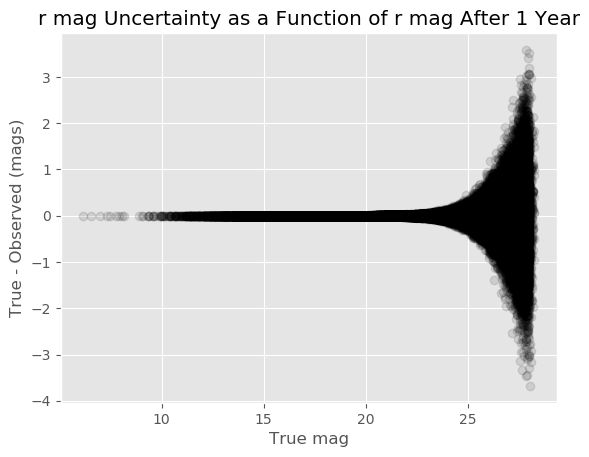

In [40]:
# A quick visual check on these new observed magnitudes:

plt.plot(truth_catalog['r'], truth_catalog['r']-observations1yr['r'], 'ko', alpha=.1)
plt.xlabel('True mag')
plt.ylabel('True - Observed (mags)')
plt.title('r mag Uncertainty as a Function of r mag After 1 Year');

In [41]:
# Converting these to colors:

early_obscolor1 = observations1yr['u'] - observations1yr['g'] # u-g
early_obscolor2 = observations1yr['g'] - observations1yr['r'] # g-r
early_obscolor3 = observations1yr['r'] - observations1yr['i'] # r-i
early_obscolor4 = observations1yr['i'] - observations1yr['z'] # i-z
early_obscolor5 = observations1yr['z'] - observations1yr['y'] # z-y

early_obscolors = np.array([early_obscolor1, early_obscolor2, early_obscolor3, early_obscolor4, early_obscolor5]).T
dist_early_obscolors, indx_match_early_obscolors = broadleafed_tree.query(early_obscolors, k=1)

In [42]:
# Collapse the dimensionality again for the sake of my computer being able to execute the code without
# running out of memory.

indx_match_early_obscolors = indx_match_early_obscolors[:,0]

In [43]:
early_teff_diff = np.array(truth_catalog['Teff']-model_atm_mags['Teff'][indx_match_early_obscolors])
early_Z_diff = np.array(truth_catalog['log_Z']-model_atm_mags['log_Z'][indx_match_early_obscolors])
early_G_diff = np.array(truth_catalog['gravity']-model_atm_mags['gravity'][indx_match_early_obscolors])

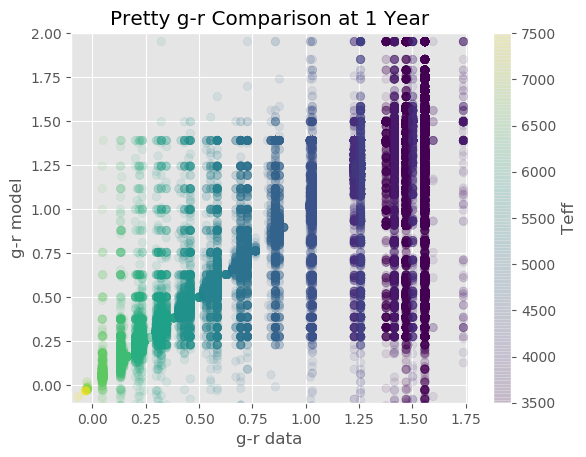

In [44]:
plt.scatter(bcolor2, color2[indx_match_early_obscolors], c=truth_catalog['Teff'], alpha=0.1)
cb = plt.colorbar()
cb.set_label('Teff')
plt.xlim(-0.1, 1.76)
plt.ylim(-0.1, 2)
plt.xlabel('g-r data')
plt.ylabel('g-r model')
plt.title('Pretty g-r Comparison at 1 Year');

Maybe a bit more spread, which seems reasonable.

### Binning true mags:

In [45]:
def binnedFitParams(true_mags, true_param, model_param, fit_indices, bin_len):
    
    """
    Bins a stellar parameter according to a list of magnitiudes. Also needs the indices from whichever KD-tree
    is being used. Also the length of each bin. Outputs binned magnitudes, standard deviation of each model_parameter
    bin, and average value of the parameter in each bin. That's as close to proper docstrings and this is going
    to get.
    """
    
    bins = np.arange(np.min(true_mags), np.max(true_mags), bin_len)

    digitize = np.digitize(true_mags, bins)

    bin_std = [
        np.std((true_param - model_param[fit_indices])[digitize == i]) for i in range(len(bins))
    ]

    # editing so it's the residuals rather than the model_parameter itself:
    
    bin_means = [
        (true_param - model_param[fit_indices])[digitize == i].mean() for i in range(len(bins))
    ]

    param_std = np.array(bin_std)[np.where(np.isnan(bin_means) == False)]

    mag_bins = np.array(bins)[np.where(np.isnan(bin_means) == False)]

    param_bin_means = np.array(bin_means)[np.where(np.isnan(bin_means) == False)]
    
    return(mag_bins, param_std, param_bin_means)

### Std. dev of Teff, G, and Z residuals binned by each broadband (ugrizy) magnitude:

 Teff at 1 & 10 years:

In [46]:
# u 1 & 10 years

u1yr_teff = binnedFitParams(truth_catalog['u'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_u1yr_teff = u1yr_teff[1]
mag_u1yr_teff = u1yr_teff[0]
temp_u1yr_teff = u1yr_teff[2]

u10yr_teff = binnedFitParams(truth_catalog['u'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_u10yr_teff = u10yr_teff[1]
mag_u10yr_teff = u10yr_teff[0]
temp_u10yr_teff = u10yr_teff[2]

/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [47]:
# r 1 year

r1yr_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_r1yr_teff = r1yr_teff[1]
mag_r1yr_teff = r1yr_teff[0]
temp_r1yr_teff = r1yr_teff[2]

# r 10 years

r10yr_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_r10yr_teff = r10yr_teff[1]
mag_r10yr_teff = r10yr_teff[0]
temp_r10yr_teff = r10yr_teff[2]

/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


A bit more plotting to check and make sure it's going as expected:

Other three colors:

In [48]:
g1yr_teff = binnedFitParams(truth_catalog['g'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_g1yr_teff = g1yr_teff[1]
mag_g1yr_teff = g1yr_teff[0]
temp_g1yr_teff = g1yr_teff[2]

g10yr_teff = binnedFitParams(truth_catalog['g'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_g10yr_teff = g10yr_teff[1]
mag_g10yr_teff = g10yr_teff[0]
temp_g10yr_teff = g10yr_teff[2]

i1yr_teff = binnedFitParams(truth_catalog['i'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_i1yr_teff = i1yr_teff[1]
mag_i1yr_teff = i1yr_teff[0]
temp_i1yr_teff = i1yr_teff[2]

i10yr_teff = binnedFitParams(truth_catalog['i'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_i10yr_teff = i10yr_teff[1]
mag_i10yr_teff = i10yr_teff[0]
temp_i10yr_teff = i10yr_teff[2]

z1yr_teff = binnedFitParams(truth_catalog['z'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_z1yr_teff = z1yr_teff[1]
mag_z1yr_teff = z1yr_teff[0]
temp_z1yr_teff = z1yr_teff[2]

z10yr_teff = binnedFitParams(truth_catalog['z'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_g1z0yr_teff = z10yr_teff[1]
mag_z10yr_teff = z10yr_teff[0]
temp_z10yr_teff = z10yr_teff[2]

/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


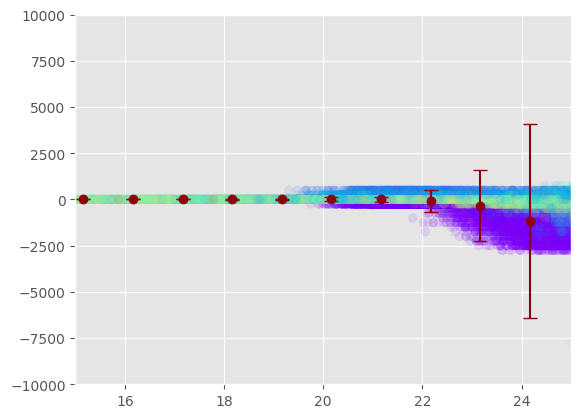

In [49]:
plt.errorbar(mag_r1yr_teff, temp_r1yr_teff, yerr=std_r1yr_teff, fmt='o', capsize=5, c='xkcd:Crimson')
plt.scatter(truth_catalog['r'], teff_diff, alpha=0.1, c=truth_catalog['Teff'], cmap='rainbow')
plt.xlim(15,25)
plt.ylim(-10000, 10000);

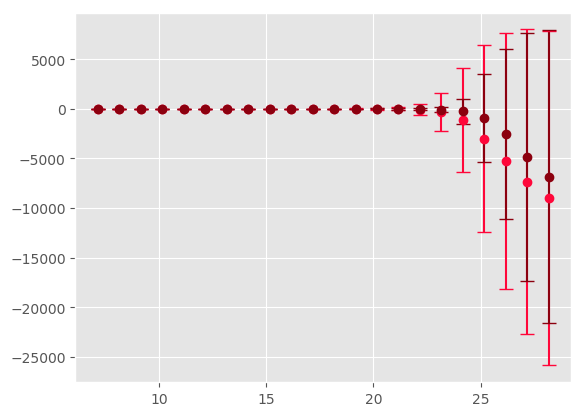

In [50]:
plt.errorbar(mag_r1yr_teff, temp_r1yr_teff, yerr=std_r1yr_teff, fmt='o', capsize=5, c='xkcd:Neon Red')
plt.errorbar(mag_r10yr_teff, temp_r10yr_teff, yerr=std_r10yr_teff, fmt='o', capsize=5, c='xkcd:Crimson');

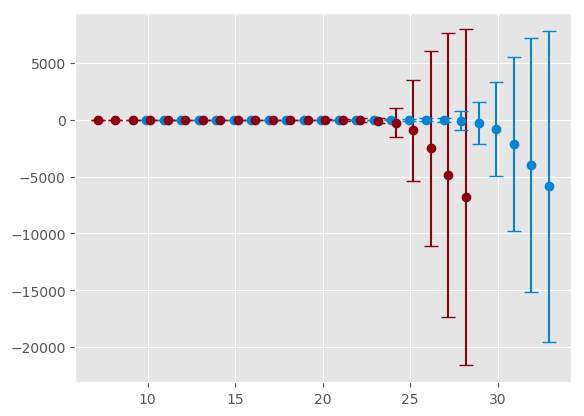

In [51]:
# blue and red:

plt.errorbar(mag_u10yr_teff, temp_u10yr_teff, yerr=std_u10yr_teff, fmt='o', capsize=5, c='xkcd:Cerulean')
plt.errorbar(mag_r10yr_teff, temp_r10yr_teff, yerr=std_r10yr_teff, fmt='o', capsize=5, c='xkcd:Crimson');

In [52]:
# Wow, now that I look at it like this u can get out to pretty high (low?) magnitudes before it all goes to hell.

In [53]:
# r 1 year

y1yr_teff = binnedFitParams(truth_catalog['y'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_early_obscolors, 1.0)

std_y1yr_teff = y1yr_teff[1]
mag_y1yr_teff = y1yr_teff[0]
temp_y1yr_teff = y1yr_teff[2]

# r 10 years

y10yr_teff = binnedFitParams(truth_catalog['y'], truth_catalog['Teff'], model_atm_mags['Teff'], indx_match_obscolors, 1.0)

std_y10yr_teff = y10yr_teff[1]
mag_y10yr_teff = y10yr_teff[0]
temp_y10yr_teff = y10yr_teff[2]

/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


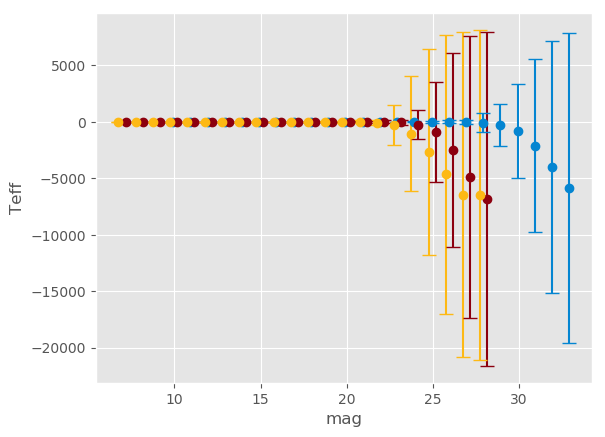

In [54]:
# blue and red and redder:

plt.errorbar(mag_u10yr_teff, temp_u10yr_teff, yerr=std_u10yr_teff, fmt='o', capsize=5, c='xkcd:Cerulean')
plt.errorbar(mag_r10yr_teff, temp_r10yr_teff, yerr=std_r10yr_teff, fmt='o', capsize=5, c='xkcd:Crimson')
plt.errorbar(mag_y10yr_teff, temp_y10yr_teff, yerr=std_y10yr_teff, fmt='o', capsize=5, c='xkcd:Orangey Yellow')
plt.xlabel('mag')
plt.ylabel('Teff');

In [55]:
# ...and y can't.

 ugrizy Log_g at 1 & 10 years:

In [56]:
zlog_g1yr = binnedFitParams(truth_catalog['z'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_early_obscolors, 1.0)

zgstd = zlog_g1yr[1]
zgmag = zlog_g1yr[0]
zgtemp = zlog_g1yr[2]


zlog_g10yr = binnedFitParams(truth_catalog['z'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_obscolors, 1.0)

zgstd_log_g10yr = zlog_g10yr[1]
zgmag_log_g10yr = zlog_g10yr[0]
zgtemp_log_g10yr = zlog_g10yr[2]

/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [57]:
ulog_g1yr = binnedFitParams(truth_catalog['u'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_early_obscolors, 1.0)

ugstd = ulog_g1yr[1]
ugmag = ulog_g1yr[0]
ugtemp = ulog_g1yr[2]


ulog_g10yr = binnedFitParams(truth_catalog['u'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_obscolors, 1.0)

ugstd_log_g10yr = ulog_g10yr[1]
ugmag_log_g10yr = ulog_g10yr[0]
ugtemp_log_g10yr = ulog_g10yr[2]

glog_g1yr = binnedFitParams(truth_catalog['g'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_early_obscolors, 1.0)

ggstd = glog_g1yr[1]
ggmag = glog_g1yr[0]
ggtemp = glog_g1yr[2]


glog_g10yr = binnedFitParams(truth_catalog['g'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_obscolors, 1.0)

ggstd_log_g10yr = glog_g10yr[1]
ggmag_log_g10yr = glog_g10yr[0]
ggtemp_log_g10yr = glog_g10yr[2]

rlog_g1yr = binnedFitParams(truth_catalog['r'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_early_obscolors, 1.0)

rgstd = rlog_g1yr[1]
rgmag = rlog_g1yr[0]
rgtemp = rlog_g1yr[2]


rlog_g10yr = binnedFitParams(truth_catalog['r'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_obscolors, 1.0)

rgstd_log_g10yr = rlog_g10yr[1]
rgmag_log_g10yr = rlog_g10yr[0]
rgtemp_log_g10yr = rlog_g10yr[2]

ilog_g1yr = binnedFitParams(truth_catalog['i'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_early_obscolors, 1.0)

igstd = ilog_g1yr[1]
igmag = ilog_g1yr[0]
igtemp = ilog_g1yr[2]

ilog_g10yr = binnedFitParams(truth_catalog['i'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_obscolors, 1.0)

igstd_log_g10yr = ilog_g10yr[1]
igmag_log_g10yr = ilog_g10yr[0]
igtemp_log_g10yr = ilog_g10yr[2]

zlog_g1yr = binnedFitParams(truth_catalog['z'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_early_obscolors, 1.0)

zgstd = zlog_g1yr[1]
zgmag = zlog_g1yr[0]
zgtemp = zlog_g1yr[2]

zlog_g10yr = binnedFitParams(truth_catalog['z'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_obscolors, 1.0)

zgstd_log_g10yr = zlog_g10yr[1]
zgmag_log_g10yr = zlog_g10yr[0]
zgtemp_log_g10yr = zlog_g10yr[2]

ylog_g1yr = binnedFitParams(truth_catalog['y'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_early_obscolors, 1.0)

ygstd = ylog_g1yr[1]
ygmag = ylog_g1yr[0]
ygtemp = ylog_g1yr[2]

ylog_g10yr = binnedFitParams(truth_catalog['y'], truth_catalog['gravity'], model_atm_mags['gravity'], indx_match_obscolors, 1.0)

ygstd_log_g10yr = ylog_g10yr[1]
ygmag_log_g10yr = ylog_g10yr[0]
ygtemp_log_g10yr = ylog_g10yr[2]

/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


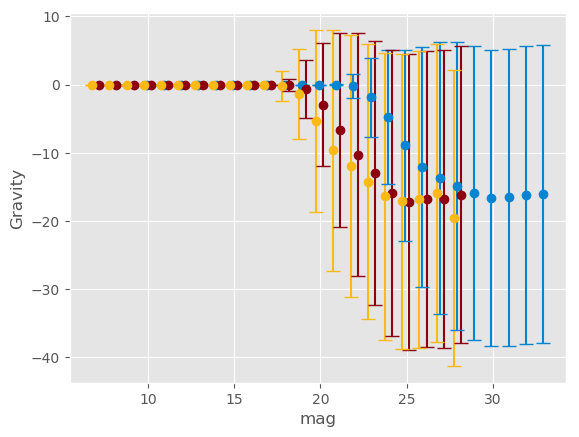

In [58]:
plt.errorbar(ugmag, ugtemp, yerr=ugstd, fmt='o', capsize=5, c='xkcd:Cerulean')
plt.errorbar(rgmag, rgtemp, yerr=rgstd, fmt='o', capsize=5, c='xkcd:Crimson')
plt.errorbar(ygmag, ygtemp, yerr=ygstd, fmt='o', capsize=5, c='xkcd:Orangey Yellow')
#plt.scatter(truth_catalog['u'], G_diff, c='black')
plt.xlabel('mag')
plt.ylabel('Gravity');

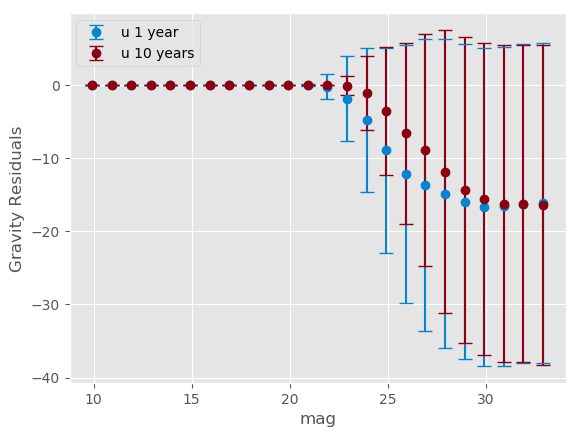

In [59]:
# u at 1 versus 10 years:

plt.errorbar(ugmag, ugtemp, yerr=ugstd, fmt='o', capsize=5, c='xkcd:Cerulean', label='u 1 year')
plt.errorbar(ugmag_log_g10yr, ugtemp_log_g10yr, yerr=ugstd_log_g10yr, fmt='o', capsize=5, c='xkcd:Crimson', label='u 10 years')
#plt.errorbar(ygmag, ygtemp, yerr=ygstd, fmt='o', capsize=5, c='xkcd:Orangey Yellow')
#plt.scatter(truth_catalog['u'], G_diff, c='black')
plt.legend()
plt.xlabel('mag')
plt.ylabel('Gravity Residuals');

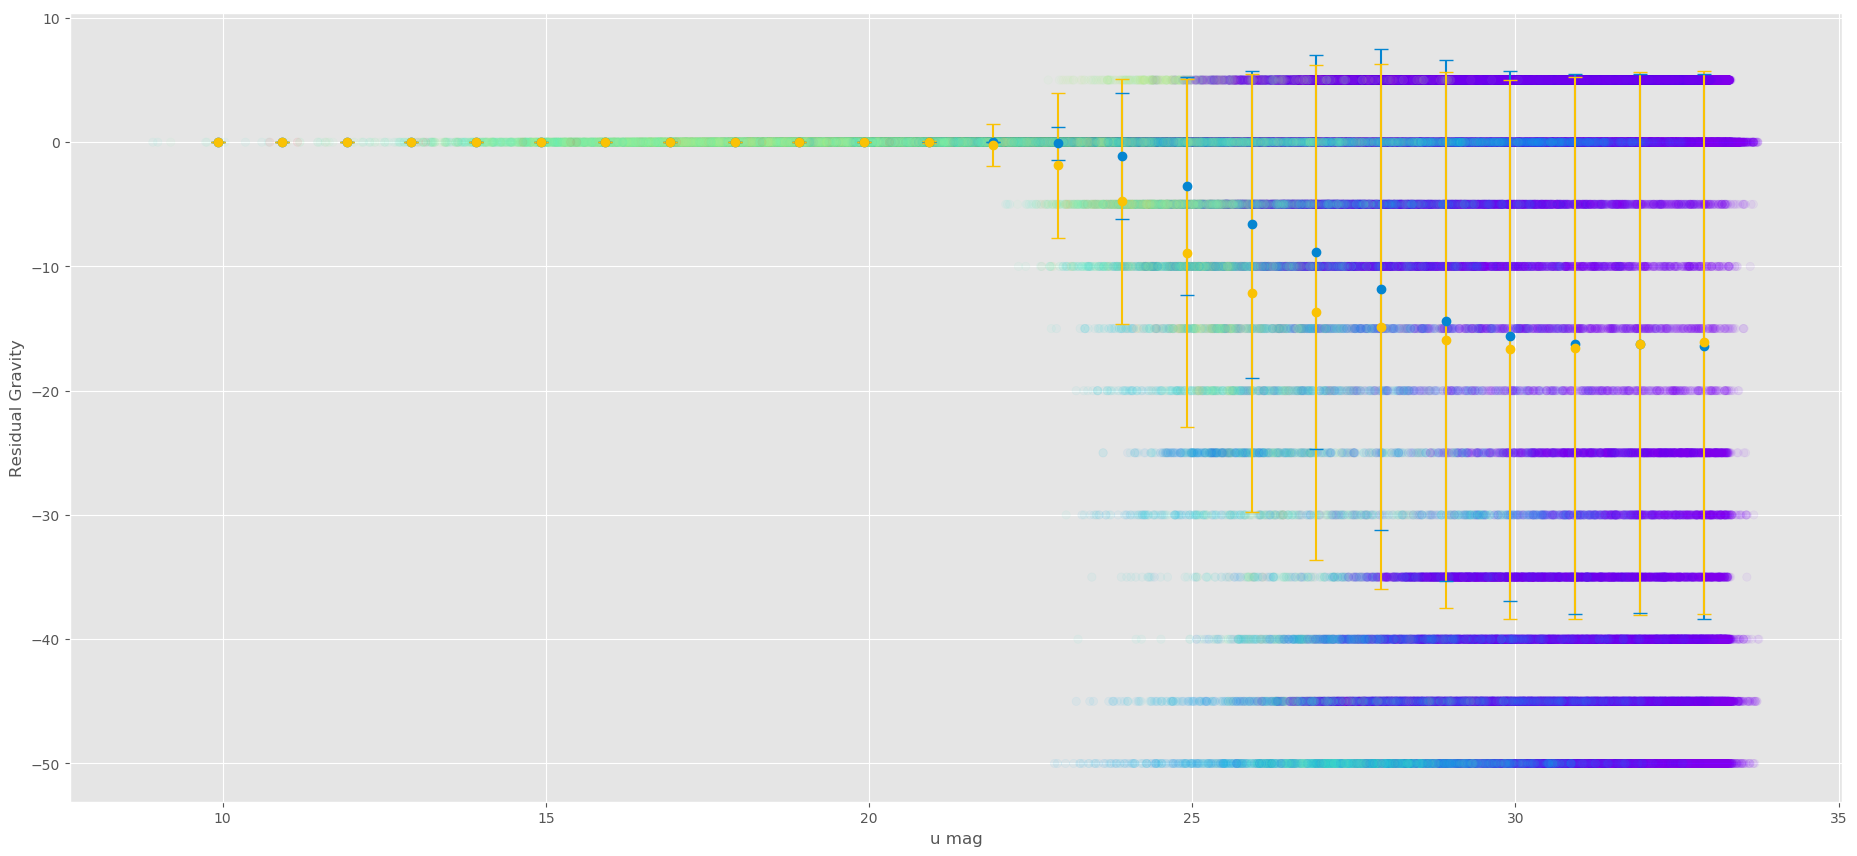

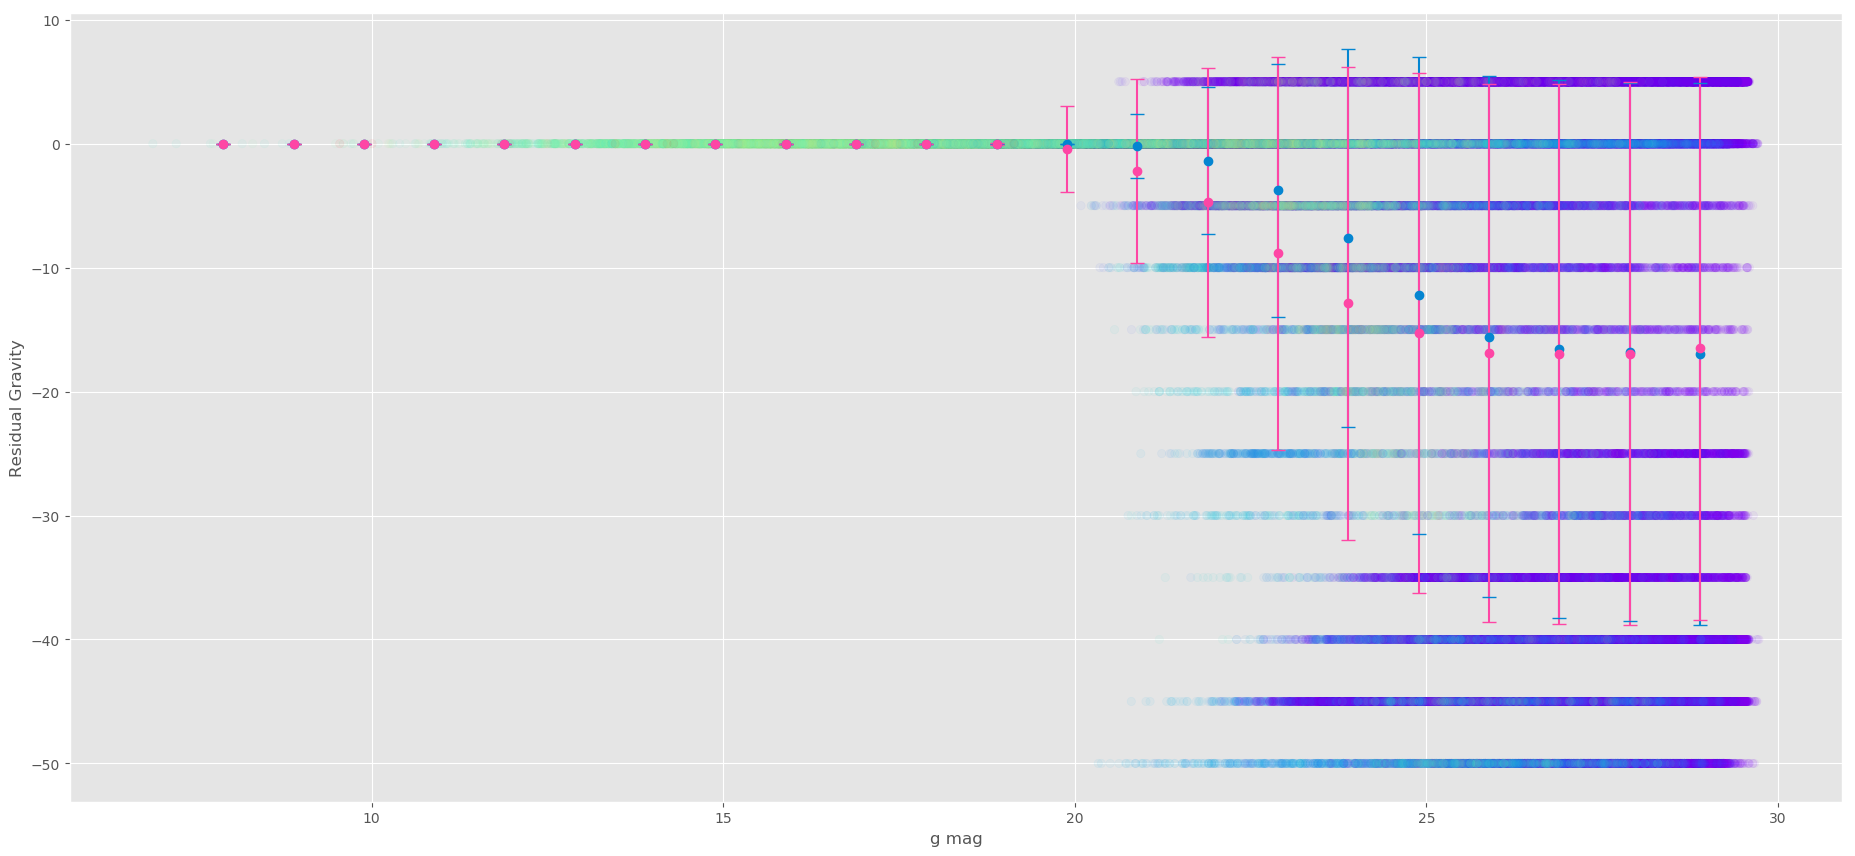

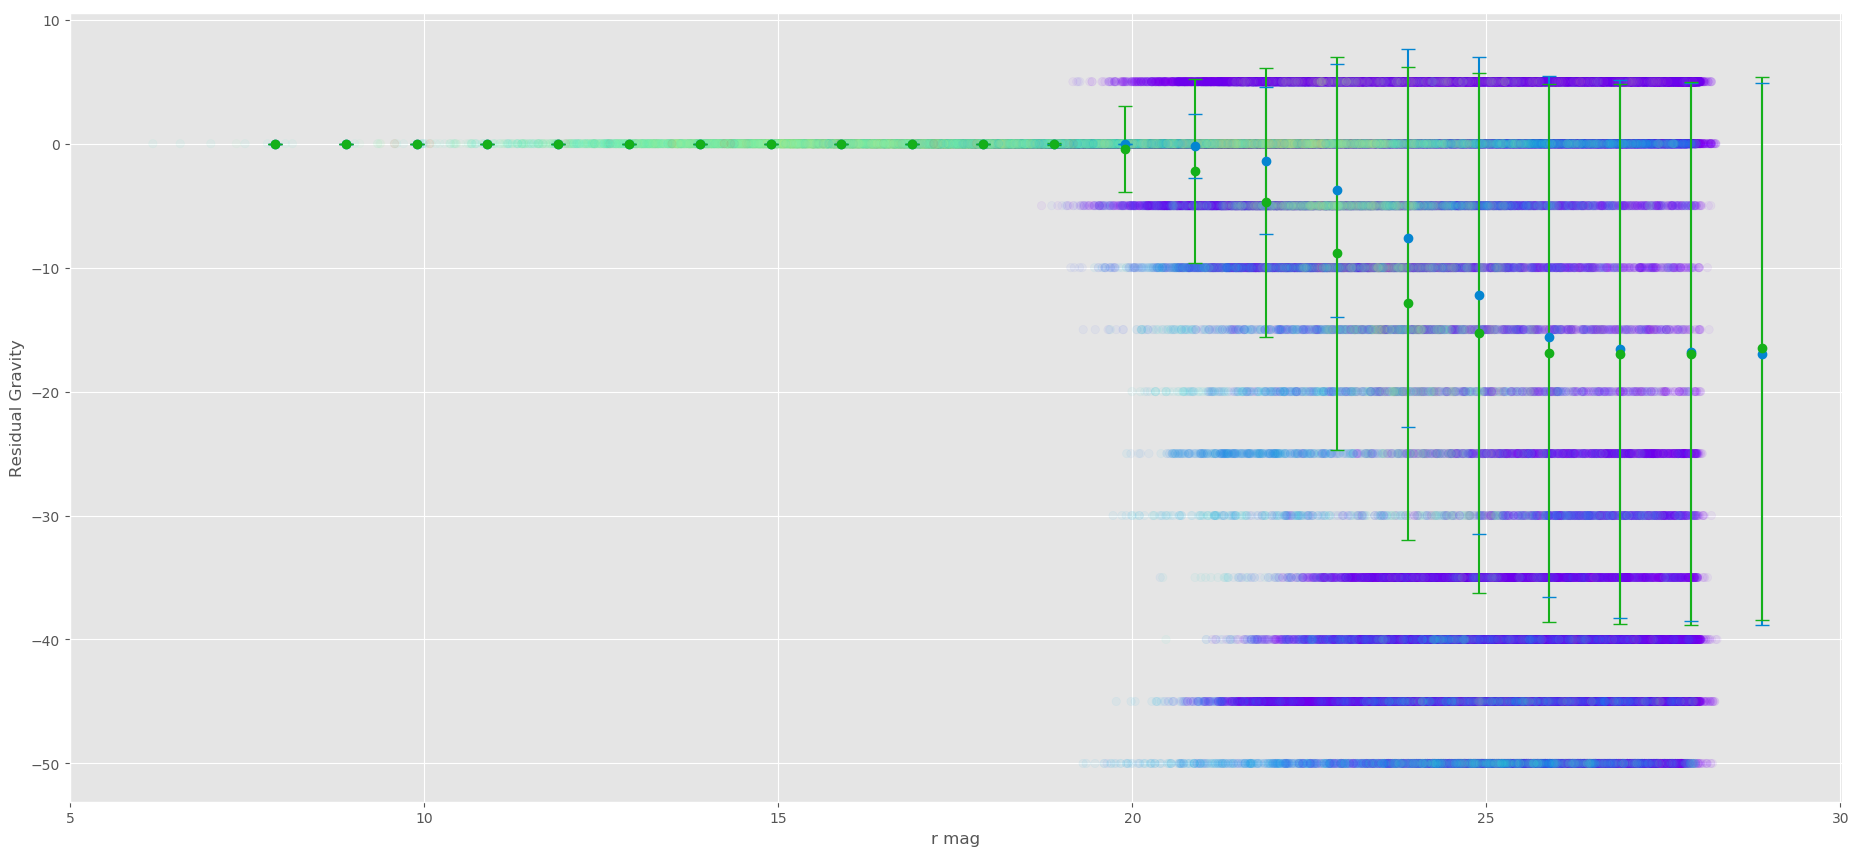

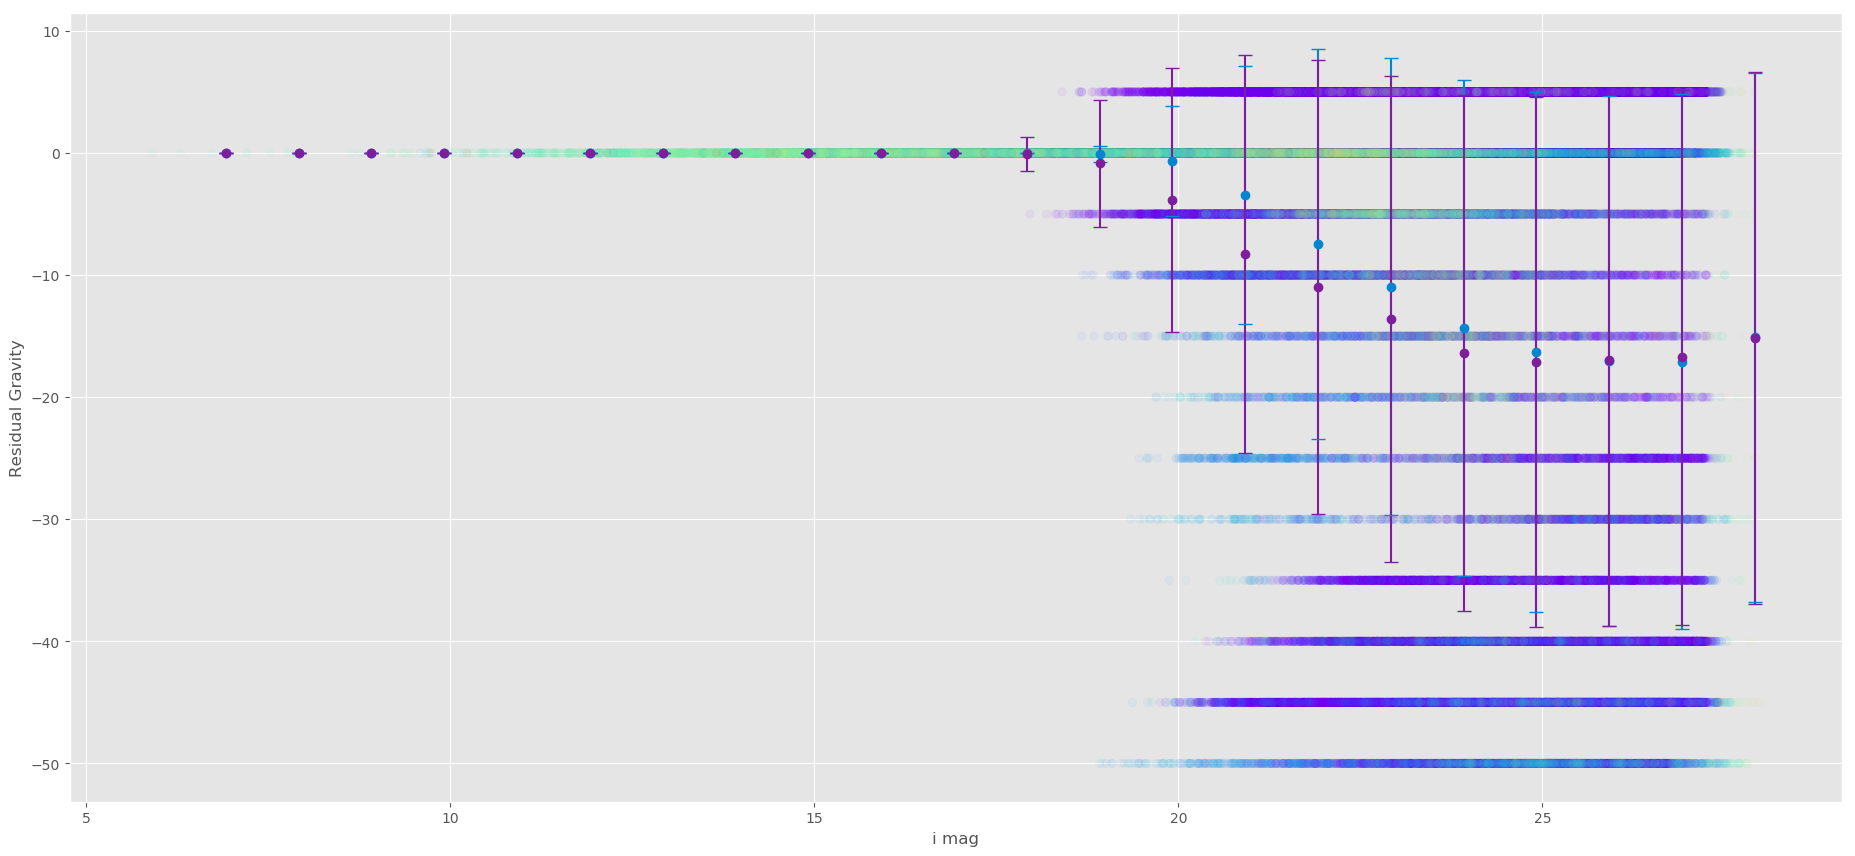

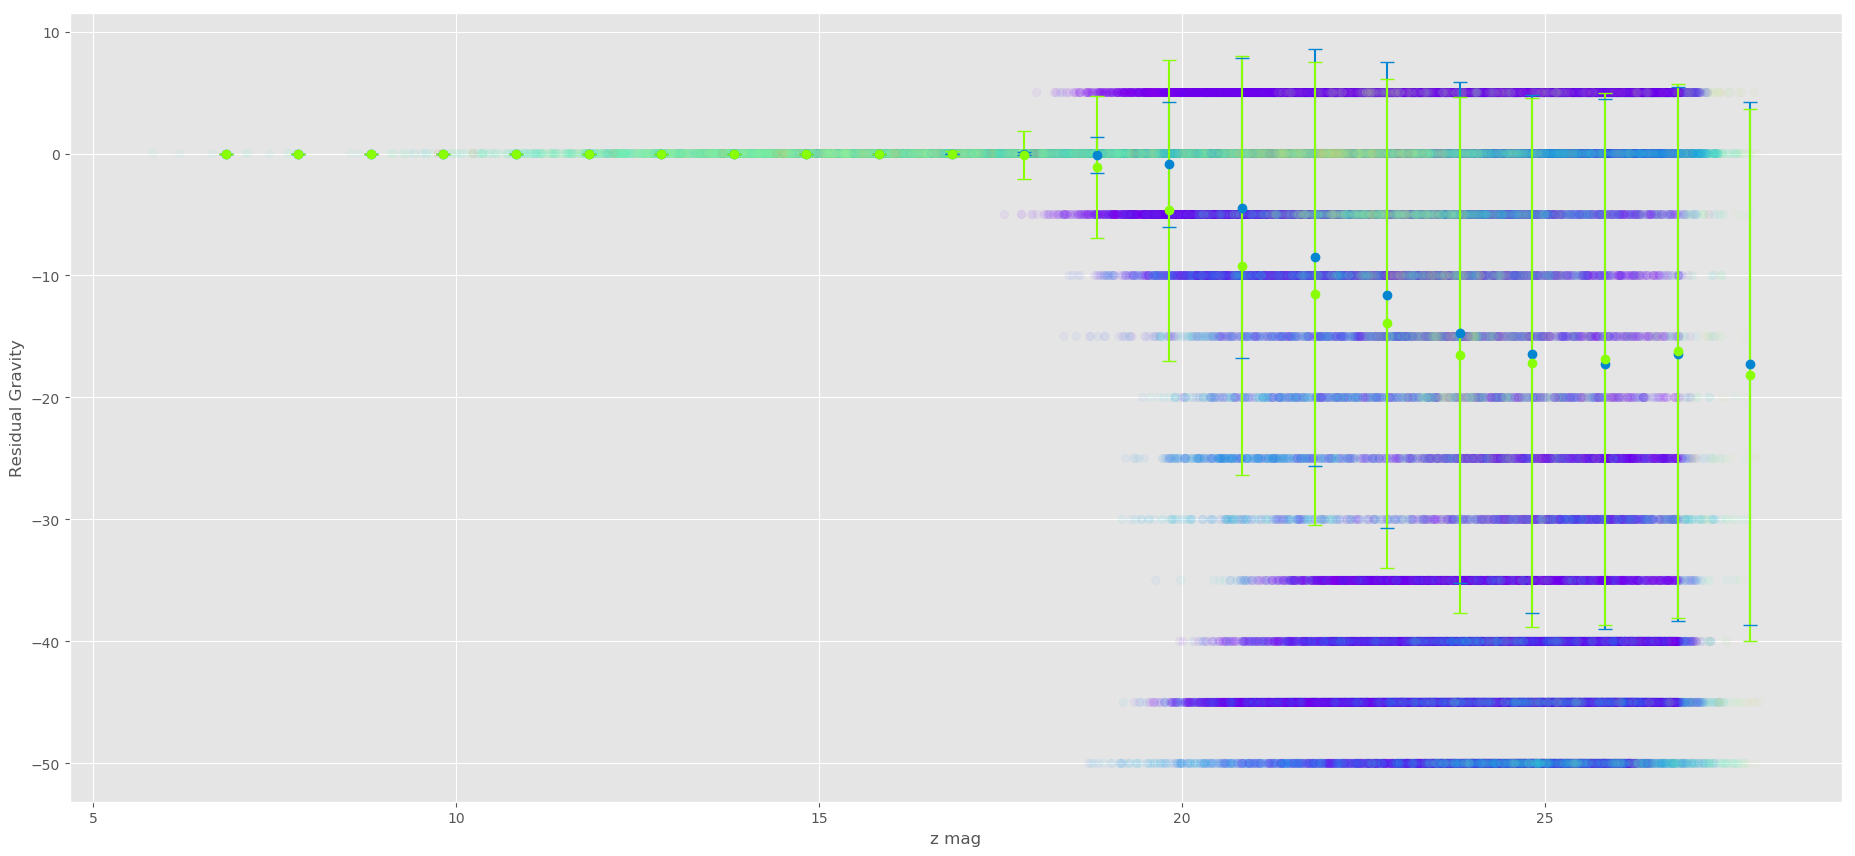

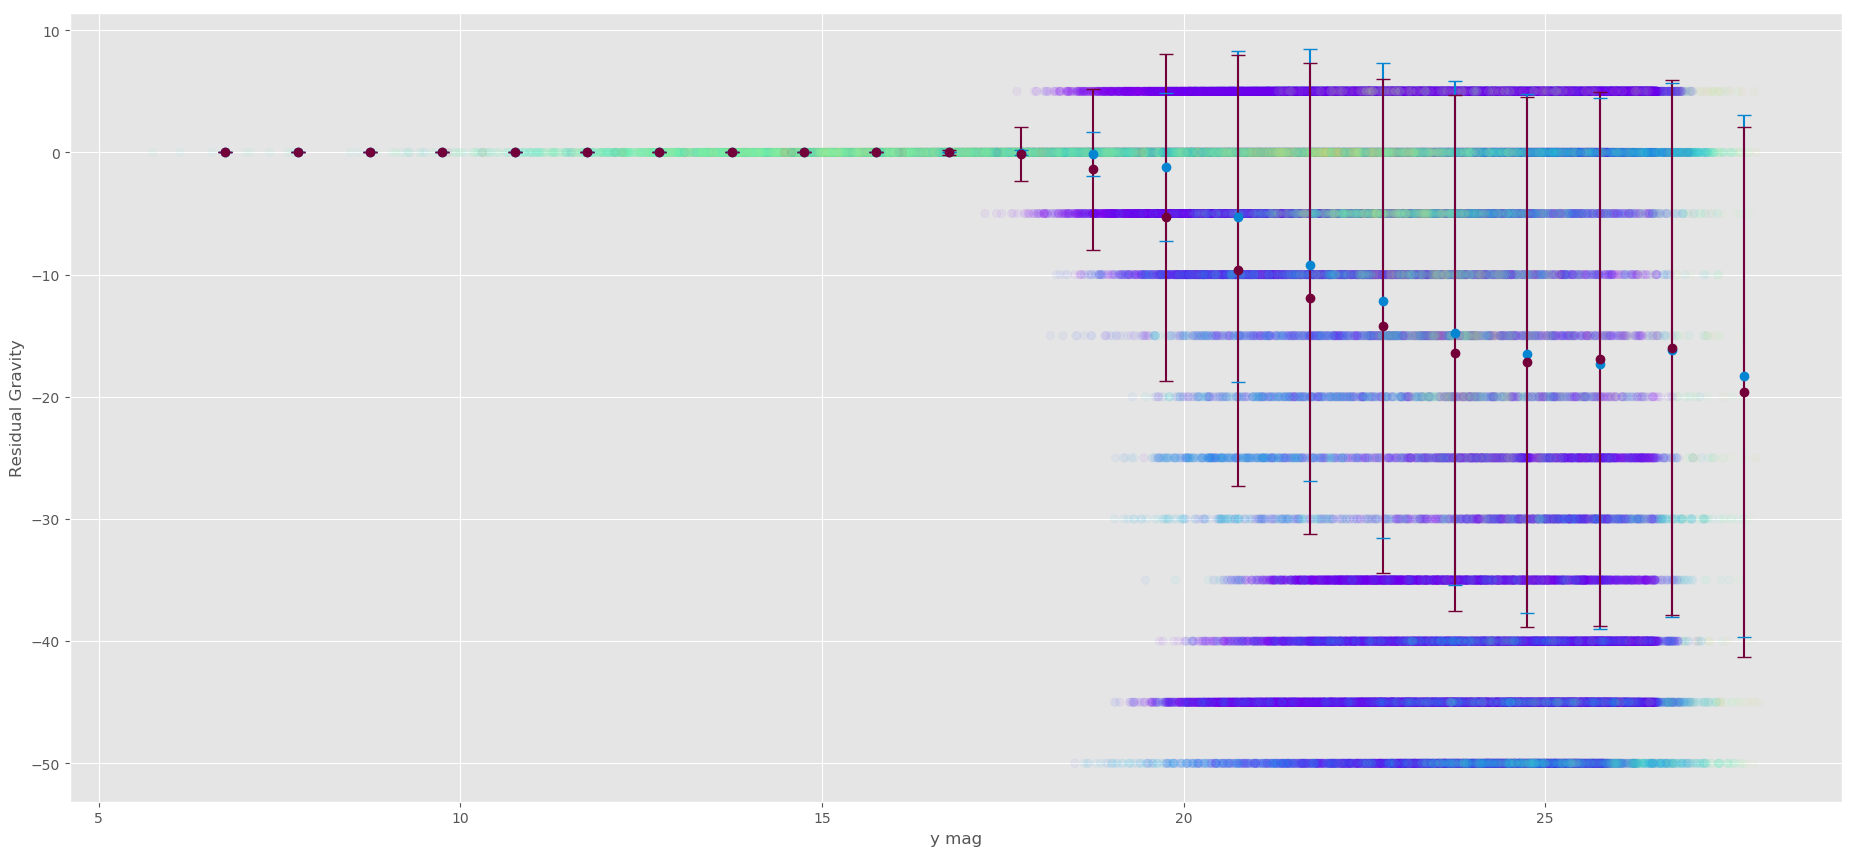

In [60]:
# All together now! Comparing 1 versus 10-year std. deviations for log_g for all the magnitudes.

# Gravity for u:

fig,ax = plt.subplots(1,1)

fig.tight_layout()
fig.set_size_inches(20,9)

ax.set_xlabel('u mag')
ax.set_ylabel('Residual Gravity')
ax.errorbar(ugmag_log_g10yr, ugtemp_log_g10yr, yerr=ugstd_log_g10yr, fmt='o', capsize=5, c='xkcd:Cerulean')
ax.errorbar(ugmag, ugtemp, yerr=ugstd, fmt='o', capsize=5, c='xkcd:Goldenrod')
ax.scatter(truth_catalog['u'], G_diff, c=truth_catalog['Teff'], cmap='rainbow', alpha=0.05)

# Gravity for g:

fig,ax = plt.subplots(1,1)

fig.tight_layout()
fig.set_size_inches(20,9)

ax.set_xlabel('g mag')
ax.set_ylabel('Residual Gravity')
ax.errorbar(ggmag_log_g10yr, ggtemp_log_g10yr, yerr=ggstd_log_g10yr, fmt='o', capsize=5, c='xkcd:Cerulean')
ax.errorbar(ggmag, ggtemp, yerr=ggstd, fmt='o', capsize=5, c='xkcd:Barbie Pink')
ax.scatter(truth_catalog['g'], G_diff, c=truth_catalog['Teff'], cmap='rainbow', alpha=0.05)

# Gravity for r:

fig,ax = plt.subplots(1,1)

fig.tight_layout()
fig.set_size_inches(20,9)

ax.set_xlabel('r mag')
ax.set_ylabel('Residual Gravity')
ax.errorbar(ggmag_log_g10yr, ggtemp_log_g10yr, yerr=ggstd_log_g10yr, fmt='o', capsize=5, c='xkcd:Cerulean')
ax.errorbar(ggmag, ggtemp, yerr=ggstd, fmt='o', capsize=5, c='xkcd:Green')
ax.scatter(truth_catalog['r'], G_diff, c=truth_catalog['Teff'], cmap='rainbow', alpha=0.05)

# Gravity for i:

fig,ax = plt.subplots(1,1)

fig.tight_layout()
fig.set_size_inches(20,9)

ax.set_xlabel('i mag')
ax.set_ylabel('Residual Gravity')
ax.errorbar(igmag_log_g10yr, igtemp_log_g10yr, yerr=igstd_log_g10yr, fmt='o', capsize=5, c='xkcd:Cerulean')
ax.errorbar(igmag, igtemp, yerr=igstd, fmt='o', capsize=5, c='xkcd:Purple')
ax.scatter(truth_catalog['i'], G_diff, c=truth_catalog['Teff'], cmap='rainbow', alpha=0.05)

# Gravity for z:

fig,ax = plt.subplots(1,1)

fig.tight_layout()
fig.set_size_inches(20,9)

ax.set_xlabel('z mag')
ax.set_ylabel('Residual Gravity')
ax.errorbar(zgmag_log_g10yr, zgtemp_log_g10yr, yerr=zgstd_log_g10yr, fmt='o', capsize=5, c='xkcd:Cerulean')
ax.errorbar(zgmag, zgtemp, yerr=zgstd, fmt='o', capsize=5, c='xkcd:Lime Green')
ax.scatter(truth_catalog['z'], G_diff, c=truth_catalog['Teff'], cmap='rainbow', alpha=0.05)

# Gravity for y:

fig,ax = plt.subplots(1,1)

fig.tight_layout()
fig.set_size_inches(20,9)

ax.set_xlabel('y mag')
ax.set_ylabel('Residual Gravity')
ax.errorbar(ygmag_log_g10yr, ygtemp_log_g10yr, yerr=ygstd_log_g10yr, fmt='o', capsize=5, c='xkcd:Cerulean')
ax.errorbar(ygmag, ygtemp, yerr=ygstd, fmt='o', capsize=5, c='xkcd:Merlot')
ax.scatter(truth_catalog['y'], G_diff, c=truth_catalog['Teff'], cmap='rainbow', alpha=0.05);

Metallicity:

###### 

In [61]:
ulog_Z1yr = binnedFitParams(truth_catalog['u'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_early_obscolors, 1.0)

uZstd = ulog_Z1yr[1]
uZmag = ulog_Z1yr[0]
uZtemp = ulog_Z1yr[2]


ulog_Z10yr = binnedFitParams(truth_catalog['u'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_obscolors, 1.0)

uZstd_log_Z10yr = ulog_Z10yr[1]
uZmag_log_Z10yr = ulog_Z10yr[0]
uZtemp_log_Z10yr = ulog_Z10yr[2]

glog_Z1yr = binnedFitParams(truth_catalog['g'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_early_obscolors, 1.0)

ggstd = glog_g1yr[1]
ggmag = glog_g1yr[0]
ggtemp = glog_g1yr[2]


glog_Z10yr = binnedFitParams(truth_catalog['g'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_obscolors, 1.0)

ggstd_log_g10yr = glog_g10yr[1]
ggmag_log_g10yr = glog_g10yr[0]
ggtemp_log_g10yr = glog_g10yr[2]

rlog_Z1yr = binnedFitParams(truth_catalog['r'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_early_obscolors, 1.0)

rZstd = rlog_Z1yr[1]
rZmag = rlog_Z1yr[0]
rZtemp = rlog_Z1yr[2]


rlog_Z10yr = binnedFitParams(truth_catalog['r'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_obscolors, 1.0)

rZstd_log_Z10yr = rlog_Z10yr[1]
rZmag_log_Z10yr = rlog_Z10yr[0]
rZtemp_log_Z10yr = rlog_Z10yr[2]

ilog_Z1yr = binnedFitParams(truth_catalog['i'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_early_obscolors, 1.0)

igstd = ilog_g1yr[1]
igmag = ilog_g1yr[0]
igtemp = ilog_g1yr[2]

ilog_Z10yr = binnedFitParams(truth_catalog['i'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_obscolors, 1.0)

igstd_log_g10yr = ilog_g10yr[1]
igmag_log_g10yr = ilog_g10yr[0]
igtemp_log_g10yr = ilog_g10yr[2]

zlog_Z1yr = binnedFitParams(truth_catalog['z'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_early_obscolors, 1.0)

zgstd = zlog_g1yr[1]
zgmag = zlog_g1yr[0]
zgtemp = zlog_g1yr[2]

zlog_Z10yr = binnedFitParams(truth_catalog['z'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_obscolors, 1.0)

zgstd_log_g10yr = zlog_g10yr[1]
zgmag_log_g10yr = zlog_g10yr[0]
zgtemp_log_g10yr = zlog_g10yr[2]


ylog_Z1yr = binnedFitParams(truth_catalog['y'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_early_obscolors, 1.0)

yZstd = ylog_Z1yr[1]
yZmag = ylog_Z1yr[0]
yZtemp = ylog_Z1yr[2]


ylog_Z10yr = binnedFitParams(truth_catalog['y'], truth_catalog['log_Z'], model_atm_mags['log_Z'], indx_match_obscolors, 1.0)

yZstd_log_Z10yr = ylog_Z10yr[1]
yZmag_log_Z10yr = ylog_Z10yr[0]
yZtemp_log_Z10yr = ylog_Z10yr[2]

/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/ichorgodbel-shamroth/miniconda3/envs/py364/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


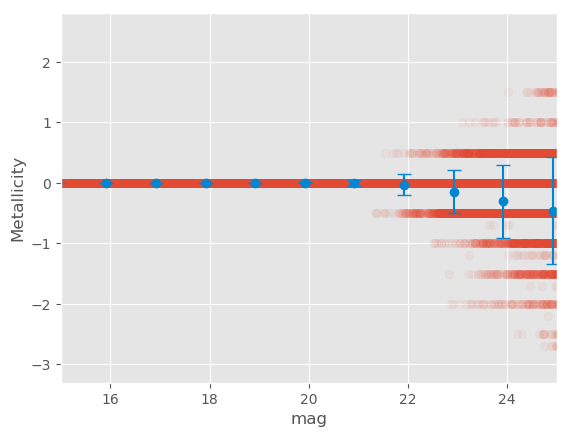

In [62]:
plt.errorbar(uZmag, uZtemp, yerr=uZstd, fmt='o', capsize=5, c='xkcd:Cerulean')
plt.scatter(truth_catalog['u'], Z_diff, alpha=0.05)
#plt.errorbar(rZmag, rZtemp, yerr=rZstd, fmt='o', capsize=5, c='xkcd:Crimson')
#plt.errorbar(yZmag, yZtemp, yerr=yZstd, fmt='o', capsize=5, c='xkcd:Orangey Yellow')

plt.xlim(15,25)
plt.xlabel('mag')
plt.ylabel('Metallicity');

Probably will want to rewrite part of this and just make a big array, this will get a bit unwieldy including the other mags. Would probably want to put the binned standard deviations in a numpy array anyway because this notebook's getting kind of long. Aside from doing that I think I'm ready for the narrowband stuff.